In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil, floor
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
def read_raw_data(filepath): # Excel file path & name 
    raw_data = pd.read_excel(filepath)
    if raw_data.columns[0] == 'Unnamed: 0':
        raw_data = raw_data.drop(['Unnamed: 0'], axis=1)

    if "Unnamed" in raw_data.columns[0]:
        raw_data = raw_data.iloc[1:,:]
        raw_data.columns = raw_data.iloc[0,:]
        raw_data = raw_data.drop([1], axis=0).reset_index(drop=True)

    if (is_datetime(raw_data[raw_data.columns[0]])) is True:
        # raw_data[raw_data.columns[0]
        raw_data = raw_data.rename(columns = {raw_data.columns[0]:'Timestamp'})\
                            .reset_index(drop=True)

    if (raw_data.columns.names[0] == 1):
        raw_data.columns.names = ['index']
        
    # Rearrange columns
    cols = ['Timestamp', 'H2', 'CO', 'CO2 Recycle', 'H2 Rich Fuel', 
            'CO Fuel', 'Load', 'S/C',
            'CO Flare MV', 'H2 Flare MV',
            'NTA Feed','NTA Fuel', 
            'NG Feed', 'NG Fuel']
    raw_data = raw_data[cols]

    return(raw_data)

In [3]:
filepath = '..\data\Y2 NTA fuel (raw data).xlsx'
raw_data = read_raw_data(filepath)
raw_data.head(5)

index,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV,NTA Feed,NTA Fuel,NG Feed,NG Fuel
0,2022-12-01 00:00:00,22336.044366,9315.53974,1451.102238,0,727.50729,76.775706,2.378685,0.004022,0,8792.848433,2147.950562,0,0
1,2022-12-01 01:00:00,22216.63404,9535.640172,1450.119602,0,512.752871,76.785974,2.38113,0.002972,0,8809.916516,2213.205512,0,0
2,2022-12-01 02:00:00,22207.793695,9602.14945,1452.515061,0,259.888601,76.794749,2.384751,0.001923,0,8772.143877,2248.528183,0,0
3,2022-12-01 03:00:00,21891.863334,9552.361241,1447.441784,0,339.9667,76.778042,2.384567,0.000873,0,8836.478105,2280.175808,0,0
4,2022-12-01 04:00:00,21840.498099,9529.234923,1442.407383,0,496.764673,76.791476,2.384538,0.026244,0,8803.398912,2197.885215,0,0


# Define Input

In [4]:
# DEFINE Y
Y="NTA Fuel"

# Apply filters

In [5]:
raw_data.columns

Index(['Timestamp', 'H2', 'CO', 'CO2 Recycle', 'H2 Rich Fuel', 'CO Fuel',
       'Load', 'S/C', 'CO Flare MV', 'H2 Flare MV', 'NTA Feed', 'NTA Fuel',
       'NG Feed', 'NG Fuel'],
      dtype='object', name='index')

In [6]:
# FILTER related Y
# Y = "NTA Fuel"
def filter_y(raw_data, Y):
    # Store initial row numbers
    row_num0 = raw_data.shape[0]
    
    if Y == "NTA Fuel":
        # Y > 0
        data = raw_data[raw_data['NTA Fuel']>0].reset_index(drop=True)
        row_num1 = data.shape[0]
        # Non Y <= 0 
        data = data[(data['NG Fuel'] == 0) | (data['NG Fuel'] < 0)].reset_index(drop=True)
        row_num2 = data.shape[0]

    elif Y == "NG Fuel":
        # Y > 0
        data = raw_data[raw_data['NG Fuel']>0].reset_index(drop=True)
        row_num1 = data.shape[0]
        # Non Y <= 0 
        data = data[(data['NTA Fuel'] == 0) | (data['NTA Fuel'] < 0)].reset_index(drop=True)
        row_num2 = data.shape[0]
        
    return data, row_num0, row_num1, row_num2

In [7]:
# Display Data cleaning / filtering stats

def generate_filtered_data(df, row_num1, row_num2):
    data = df.copy()
    data = data[data.CO > 4000].reset_index(drop=True)
    # print('CO <= 4000 : =', row_num2 - data.shape[0], 'rows')
    row_num3 = data.shape[0]

    # Load > 50
    data = data[data.Load > 50].reset_index(drop=True)
    # print('After filtering Load > 50 : Shape =', data.shape)
    # print('Load > 50 : =', row_num3-data.shape[0], 'rows')
    row_num4 = data.shape[0]

    # CO Flare MV < 3
    data = data[data['CO Flare MV'] < 3].reset_index(drop=True)
    # print('CO Flare MV < 3 : =', row_num4-data.shape[0], 'rows')
    row_num5 = data.shape[0]

    # H2 Flare MV < 3
    data = data[data['H2 Flare MV'] < 3].reset_index(drop=True)
    # print('H2 Flare MV < 3 : =', row_num5-data.shape[0], 'rows')
    row_num6 = data.shape[0]

    # CO Fuel < 500
    data = data[data['CO Fuel'] < 500].reset_index(drop=True)
    # print('CO Fuel < 500 : =', row_num6-data.shape[0], 'rows')
    row_num7 = data.shape[0]

    print('Row filters\n')
    print('Raw data row number :', row_num0, 'rows')
    print('NTA Fuel > 0        :', row_num0 - row_num1, 'rows')
    print('NG Fuel <= 0        :', row_num1 - row_num2, 'rows')
    print('CO <= 4000          :', row_num2 - row_num3, 'rows')
    print('Load > 50           :', row_num3 - row_num4, 'rows')
    print('CO Flare MV < 3     :', row_num4 - row_num5, 'rows')
    print('H2 Flare MV < 3     :', row_num5 - row_num6, 'rows')
    print('CO Fuel < 500       :', row_num6 - row_num7, 'rows')
    print('After filtering     :', row_num7,'rows')
    print('')

    row_removal_percent = round(((row_num0 - row_num7) / row_num0)*100, 2)
    print('% of row removal    : ', row_removal_percent, '%')
    
    return data

In [8]:
# ! Write function to store & return data removal report

In [9]:
# Check N/A NTA Fuel
# data

# Remove variables

In [10]:
Y

'NTA Fuel'

In [11]:
def remove_vars(data, Y):

    # Remove irrelevant Y variables
    # y_to_remove = ['NTA Feed','NG Feed','NG Fuel']
    y_to_remove = ['NTA Feed','NG Feed','NG Fuel'] if Y=="NTA Fuel" else ['NG Feed','NTA Feed','NTA Fuel'] if Y=="NG Fuel" else []
    y_to_remove
    
    # Remove X-variables that are only included for filtering condition:
    # [Load, CO Flare, H2 Flare, CO Fuel]

    cols_to_remove = y_to_remove
    filtering_var_to_remove = ['Timestamp','Load', 'CO Flare MV', 'H2 Flare MV', 'CO Fuel']

    cols_to_remove.extend(filtering_var_to_remove)
    
    data_removed_col = data.copy()
    for col in cols_to_remove:
        if col in data.columns.tolist():
            print(col)
            data_removed_col = data_removed_col.drop([col], axis=1)
    # print(data.columns.tolist())
    data_removed_col = data_removed_col.astype('float')
    
    return data_removed_col

# Plotting functions

In [12]:
# Defining function to set figure size
def figure(a,b):
    sns.set(rc={'figure.figsize':(a,b)})

In [13]:
# Defining function to generate distplot
# Input: df, figure(a,b)
def distplot(df,a,b):
    ## GENERATE DIST PLOT
    df_numeric = df.copy()
    figure(a,b)

    plt_cols = 1                                                           # Customized no. of columns in subplot
    plt_rows = ceil(len(df_numeric.columns)/plt_cols)                      # Set the no. of rows in subplot by dividing: 
                                                                           #  roundup(no. of variables / no. of columns)

    fig, axes = plt.subplots(plt_rows,plt_cols)
    fig.suptitle("Distribution Plots of Numerical Variables \n (x-axis: Variable) \n (y-axis: Distribution proportion)", 
                 fontsize="x-large")

    axes = axes.ravel()

    for i in range(0, len(df_numeric.columns)):
        sns.distplot(df_numeric.iloc[:,i], ax=axes[i])                     # Plot countplot for each categorical variable
        axes[i].set_title(df_numeric.columns[i], size=15) # Set title of every subplot
        axes[i].tick_params(axis='x', labelrotation=90, pad=0)             # Rotate x-axis of every subplot
        axes[i].set_xlabel('')                                             # Turn off subplots' x-axis titles for tidiness
    fig.tight_layout(rect=[0, 0, 1, 0.975])
    # return fig

In [14]:
# Defining function to generate boxplot
# data.drop(['Timestamp'], axis=1)
# Input: df, figure(a,b)
def boxplot(df,a,b):
    ## GENERATE BOXPLOT
    df_boxplot = df.copy()
    figure(a,b)
    plt_cols = 1                                                           # Customized no. of columns in subplot
    plt_rows = ceil(len(df_boxplot.columns)/plt_cols)                       # Set the no. of rows in subplot by dividing: 
                                                                           #  roundup(no. of variables / no. of columns)

    fig, axes = plt.subplots(plt_rows,plt_cols)
    fig.suptitle("Distribution Plots of Numerical Variables \n (x-axis: Variable) \n (y-axis: Distribution proportion)", 
                 fontsize="x-large")

    axes = axes.ravel()

    for i in range(0, len(df_boxplot.columns)):
        # sns.distplot(df_numeric.iloc[:,i], ax=axes[i])                     # Plot countplot for each categorical variable
        sns.boxplot(df_boxplot.iloc[:,i], orient="v", ax=axes[i])
        axes[i].set_title(df_boxplot.columns[i], size=15) # Set title of every subplot
        axes[i].tick_params(axis='x', labelrotation=90, pad=0)             # Rotate x-axis of every subplot
        axes[i].set_xlabel('')                                             # Turn off subplots' x-axis titles for tidiness
    fig.tight_layout(rect=[0, 0, 1, 0.975])
    # return fig

In [15]:
# Defining function to generate scatter
# data.drop(['Timestamp'], axis=1)
# Input: df, figure(a,b)
def scatterplot(df,a,b):
    ## GENERATE BOXPLOT
    df_scatter = df.copy()
    figure(a,b)
    plt_cols = 1                                                           # Customized no. of columns in subplot
    plt_rows = ceil(len(df_scatter.columns)/plt_cols)                      # Set the no. of rows in subplot by dividing: 
                                                                           #  roundup(no. of variables / no. of columns)

    fig, axes = plt.subplots(plt_rows,plt_cols)
    fig.suptitle("Scatter plots of Numerical Variables \n (x-axis: Variable) \n (y-axis: )", 
                 fontsize="x-large")

    axes = axes.ravel()

    for i in range(0, len(df_scatter.columns)):
        # sns.distplot(df_numeric.iloc[:,i], ax=axes[i])                   # Plot countplot for each categorical variable
        # sns.boxplot(df_scatter.iloc[:,i], orient="v", ax=axes[i])
        sns.scatterplot(df_scatter.index, df_scatter.iloc[:,i], ax=axes[i], marker='.')
        axes[i].set_title(df_scatter.columns[i], size=15)                  # Set title of every subplot
        axes[i].tick_params(axis='x', labelrotation=90, pad=0)             # Rotate x-axis of every subplot
        axes[i].set_xlabel('')                                             # Turn off subplots' x-axis titles for tidiness
    fig.tight_layout(rect=[0, 0, 1, 0.975])
    # return fig

# Check variation

In [16]:
# Display data variation stats
def variation_test(df):
    d = df.copy()
    mean = np.mean(d['NTA Fuel'])
    std = np.std(d['NTA Fuel'])
    d_range = np.max(d['NTA Fuel']) - np.min(d['NTA Fuel'])
    maxv = np.max(d['NTA Fuel'])
    minv = np.min(d['NTA Fuel'])
    upper_lim = mean + 2*std
    lower_lim = mean - 2*std

    print('mean: ', mean)
    print('std: ', std)
    print('max: ', maxv)
    print('min: ', minv)
    print('upper_lim: ', upper_lim)
    print('lower_lim: ', lower_lim)

    print('range %: ',  round((std/d_range)*100, 2))
    
    return mean, std, upper_lim, lower_lim

# Transform population

In [17]:
# STOP

In [18]:
from scipy.stats import boxcox
from scipy.stats import yeojohnson
# from scipy.stats import shapiro   # Measure normality by Shapiro Wilk

In [19]:
# CO, H2, CO2 Recycle, S/C, H2 Rich Fuel, NG Offgas

In [20]:
def transform_data(df, algo):
    df_transform = df.copy()
    for col in df_transform.columns.tolist():
        df_transform = df.copy()
        if algo == 'log':
            df_transform[col] = np.log1p(df_transform[col])
        elif algo == 'johnson':
            df_transform[col] = pd.Series(yeojohnson(df_transform[col])[0])
        return df_transform

# Scaling

In [21]:
# Import Feature Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [22]:
def scale_data(df, scaler):
    df_scaled = df.copy()
    if scaler == 'standard':
        # define standard scaler
        scaler = StandardScaler()
    elif scaler == 'minmax':
        # define MinMax scaler
        scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(scaled, columns=df_scaled.columns)
    return(df_scaled)

# Correlation, Covariance

In [23]:
# Features Correlation & Multicollinearity
def corr(df):
    df_corr = df.copy()
    # corr_table = df_corr.corr()[['NTA Fuel']].abs().sort_values('NTA Fuel', ascending=False)
    corr_table = df_corr.corr().sort_values('NTA Fuel', ascending=False)
    return corr_table

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def covariance(df):
    df_cov = df.copy()
    X = df_cov.copy()

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif_data

In [25]:
# VIF (2)
# Specify removed variable based on correlation / VIF

def covariance2(df, list_to_remove): 
# Input: 1 dataframe, 1 list of variables to be removed
# e.g.: covariance2(data_removed_col, ['H2'])
    cols_to_remove = []
    cols_to_remove.extend(list_to_remove)
    
    df_cov = df.copy()
    df_cov = df_cov.loc[:, ~df_cov.columns.isin(cols_to_remove)]

    # calculating VIF for each feature
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_cov.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df_cov.values, i) for i in range(len(df_cov.columns))]

    return vif_data

## Test transformation

In [26]:
# 

# Variation analysis & data range determination

In [27]:
# 

## SciLearnKit OLS Model

In [28]:
from sklearn.model_selection import train_test_split #linear regression data split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet #linear regression
from sklearn.metrics import r2_score #linear regression metrics

In [29]:
Y

'NTA Fuel'

In [30]:
def lr_model(df, Y): # Input e.g.: df, Y='NTA Fuel'
    y_variable = Y
    X = df.drop([y_variable], axis=1)
    y = df[[y_variable]]
    
    RANDOM_STATE = 40
    # Data Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

    lr_model = LinearRegression(fit_intercept=True, n_jobs=-1)
    lr_model.fit(X_train, y_train)
    model_intercept = lr_model.intercept_

    features = X.columns.tolist()
    coefficients = lr_model.coef_.tolist()
    features.insert(0, 'intercept')
    coefficients.insert(0, model_intercept)

    coef = coefficients[0].tolist()
    coef.extend(coefficients[1])

    model_coefficients = pd.DataFrame({'features': features, 'coefficients': coef})
    
    training_r2 = round(r2_score(y_train, lr_model.predict(X_train)), 4)
    testing_r2  = round(r2_score(y_test,  lr_model.predict(X_test)), 4)
    
    #calculate Adj R2
    n= len(X_train)
    p = len(X.columns)
    R2 = testing_r2
    testing_adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

    print('OLS Training R2    : ', round(training_r2, 4))
    print('OLS Testing R2     : ', round(testing_r2, 4))
    print('OLS Testing Adj-R2 : ', round(testing_adj_R2, 4))
    
    return(lr_model, model_coefficients, training_r2, testing_r2, testing_adj_R2)
    # CO Flare
    # H2 Flare
    # Check variables inclusion based on p-value

## Lasso

In [31]:
def lasso_model(df, Y): # Input e.g.: df, Y='NTA Fuel'
    y_variable = Y
    X = df.drop([y_variable], axis=1)
    y = df[[y_variable]]
    
    RANDOM_STATE = 40
    # Data Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

    clf_model = Lasso(alpha=0.3)
    clf_model.fit(X_train, y_train)
    # model_intercept = clf_model.intercept_
    model_intercept = clf_model.intercept_.tolist()[0]

    features = X.columns.tolist()
    coefficients = clf_model.coef_.tolist()
    features.insert(0, 'intercept')
    coefficients.insert(0, model_intercept)

    # coef = coefficients[0].tolist()
    # coef.extend(coefficients[1])
    coef = pd.Series(coefficients)

    model_coefficients = pd.DataFrame({'features': features, 'coefficients': coef})
    
    training_r2 = round(r2_score(y_train, clf_model.predict(X_train)), 4)
    testing_r2  = round(r2_score(y_test,  clf_model.predict(X_test)), 4)

    #calculate Adj R2
    n= len(X_train)
    p = len(X.columns)
    R2 = testing_r2
    testing_adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

    print('Lasso Training R2    : ', round(training_r2, 4))
    print('Lasso Testing R2     : ', round(testing_r2, 4))
    print('Lasso Testing Adj-R2 : ', round(testing_adj_R2, 4))
    
    return(clf_model, model_coefficients, training_r2, testing_r2, testing_adj_R2)
    # CO Flare
    # H2 Flare
    # Check variables inclusion based on p-value

In [32]:
# lasso_model(df_model, Y)

## ElasticNet

In [33]:
def elasticnet(df, Y):
    y_variable = Y
    X = df.drop([y_variable], axis=1)
    y = df[[y_variable]]

    RANDOM_STATE = 40
    # Data Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

    en_model = ElasticNet(random_state=RANDOM_STATE)
    en_model.fit(X_train, y_train)
    # model_intercept = clf_model.intercept_
    model_intercept = en_model.intercept_.tolist()[0]
    model_intercept

    features = X.columns.tolist()
    coefficients = en_model.coef_.tolist()
    features.insert(0, 'intercept')
    coefficients.insert(0, model_intercept)

    coef = pd.Series(coefficients)

    model_coefficients = pd.DataFrame({'features': features, 'coefficients': coef})

    training_r2 = round(r2_score(y_train, en_model.predict(X_train)), 4)
    testing_r2  = round(r2_score(y_test,  en_model.predict(X_test)), 4)

    #calculate Adj R2
    n= len(X_train)
    p = len(X.columns)
    R2 = testing_r2
    testing_adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

    print('EN Training R2    : ', round(training_r2, 4))
    print('EN Testing R2     : ', round(testing_r2, 4))
    print('EN Testing Adj-R2 : ', round(testing_adj_R2, 4))
    
    return(en_model, model_coefficients, training_r2, testing_r2, testing_adj_R2)

In [34]:
# elasticnet(data_removed_col, Y)

## Run Program

In [35]:
import pandas as pd
import numpy as np

In [36]:
# def main():
#     print('Hello World')

### o Define Input

In [37]:
filepath = '..\data\Y2 NTA fuel (raw data).xlsx'
Y = "NTA Fuel"

#### o Read Data

In [38]:
raw_data = read_raw_data(filepath)
raw_data

index,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV,NTA Feed,NTA Fuel,NG Feed,NG Fuel
0,2022-12-01 00:00:00,22336.044366,9315.53974,1451.102238,0,727.50729,76.775706,2.378685,0.004022,0,8792.848433,2147.950562,0,0
1,2022-12-01 01:00:00,22216.63404,9535.640172,1450.119602,0,512.752871,76.785974,2.38113,0.002972,0,8809.916516,2213.205512,0,0
2,2022-12-01 02:00:00,22207.793695,9602.14945,1452.515061,0,259.888601,76.794749,2.384751,0.001923,0,8772.143877,2248.528183,0,0
3,2022-12-01 03:00:00,21891.863334,9552.361241,1447.441784,0,339.9667,76.778042,2.384567,0.000873,0,8836.478105,2280.175808,0,0
4,2022-12-01 04:00:00,21840.498099,9529.234923,1442.407383,0,496.764673,76.791476,2.384538,0.026244,0,8803.398912,2197.885215,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,2023-04-30 19:00:00,22368.944101,8681.679178,0,0,0,72.717883,2.227629,0,0,8639.463569,2134.989965,0,0
3620,2023-04-30 20:00:00,22532.79531,8734.909038,0,0,0,72.387455,2.242916,0,0,8577.57099,2152.659748,0,0
3621,2023-04-30 21:00:00,22120.599271,8560.467956,0,0,0,71.015416,2.280504,0,0,8457.715324,2057.044041,0,0
3622,2023-04-30 22:00:00,21998.286158,8614.971588,0,0,0,70.892897,2.285601,0,0,8454.635152,2067.092651,0,0


#### o FILTER related Y

In [39]:
# FILTER related Y
# Y = "NTA Fuel"
# DEFINE Y
# Y="NTA Fuel"
data, row_num0, row_num1, row_num2 = filter_y(raw_data, Y)

# data = data[data.Timestamp > '2023-04-01 00:00:00'].reset_index(drop=True)
# data = data[(data.Timestamp >= '2022-12-01 00:00:00') & (data.Timestamp < '2023-01-01 00:00:00')].reset_index(drop=True)
data

index,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV,NTA Feed,NTA Fuel,NG Feed,NG Fuel
0,2022-12-01 00:00:00,22336.044366,9315.53974,1451.102238,0,727.50729,76.775706,2.378685,0.004022,0,8792.848433,2147.950562,0,0
1,2022-12-01 01:00:00,22216.63404,9535.640172,1450.119602,0,512.752871,76.785974,2.38113,0.002972,0,8809.916516,2213.205512,0,0
2,2022-12-01 02:00:00,22207.793695,9602.14945,1452.515061,0,259.888601,76.794749,2.384751,0.001923,0,8772.143877,2248.528183,0,0
3,2022-12-01 03:00:00,21891.863334,9552.361241,1447.441784,0,339.9667,76.778042,2.384567,0.000873,0,8836.478105,2280.175808,0,0
4,2022-12-01 04:00:00,21840.498099,9529.234923,1442.407383,0,496.764673,76.791476,2.384538,0.026244,0,8803.398912,2197.885215,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,2023-04-30 19:00:00,22368.944101,8681.679178,0,0,0,72.717883,2.227629,0,0,8639.463569,2134.989965,0,0
3620,2023-04-30 20:00:00,22532.79531,8734.909038,0,0,0,72.387455,2.242916,0,0,8577.57099,2152.659748,0,0
3621,2023-04-30 21:00:00,22120.599271,8560.467956,0,0,0,71.015416,2.280504,0,0,8457.715324,2057.044041,0,0
3622,2023-04-30 22:00:00,21998.286158,8614.971588,0,0,0,70.892897,2.285601,0,0,8454.635152,2067.092651,0,0


In [40]:
# data, row_num1, row_num2 = filter_y(raw_data, Y)
# data = generate_filtered_data(data, row_num1, row_num2)
data

index,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV,NTA Feed,NTA Fuel,NG Feed,NG Fuel
0,2022-12-01 00:00:00,22336.044366,9315.53974,1451.102238,0,727.50729,76.775706,2.378685,0.004022,0,8792.848433,2147.950562,0,0
1,2022-12-01 01:00:00,22216.63404,9535.640172,1450.119602,0,512.752871,76.785974,2.38113,0.002972,0,8809.916516,2213.205512,0,0
2,2022-12-01 02:00:00,22207.793695,9602.14945,1452.515061,0,259.888601,76.794749,2.384751,0.001923,0,8772.143877,2248.528183,0,0
3,2022-12-01 03:00:00,21891.863334,9552.361241,1447.441784,0,339.9667,76.778042,2.384567,0.000873,0,8836.478105,2280.175808,0,0
4,2022-12-01 04:00:00,21840.498099,9529.234923,1442.407383,0,496.764673,76.791476,2.384538,0.026244,0,8803.398912,2197.885215,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,2023-04-30 19:00:00,22368.944101,8681.679178,0,0,0,72.717883,2.227629,0,0,8639.463569,2134.989965,0,0
3620,2023-04-30 20:00:00,22532.79531,8734.909038,0,0,0,72.387455,2.242916,0,0,8577.57099,2152.659748,0,0
3621,2023-04-30 21:00:00,22120.599271,8560.467956,0,0,0,71.015416,2.280504,0,0,8457.715324,2057.044041,0,0
3622,2023-04-30 22:00:00,21998.286158,8614.971588,0,0,0,70.892897,2.285601,0,0,8454.635152,2067.092651,0,0


#### o Removed variables

In [41]:
data_removed_col = remove_vars(data, Y)
data_removed_col

NTA Feed
NG Feed
NG Fuel
Timestamp
Load
CO Flare MV
H2 Flare MV
CO Fuel


index,H2,CO,CO2 Recycle,H2 Rich Fuel,S/C,NTA Fuel
0,22336.044366,9315.539740,1451.102238,0.0,2.378685,2147.950562
1,22216.634040,9535.640172,1450.119602,0.0,2.381130,2213.205512
2,22207.793695,9602.149450,1452.515061,0.0,2.384751,2248.528183
3,21891.863334,9552.361241,1447.441784,0.0,2.384567,2280.175808
4,21840.498099,9529.234923,1442.407383,0.0,2.384538,2197.885215
...,...,...,...,...,...,...
3619,22368.944101,8681.679178,0.000000,0.0,2.227629,2134.989965
3620,22532.795310,8734.909038,0.000000,0.0,2.242916,2152.659748
3621,22120.599271,8560.467956,0.000000,0.0,2.280504,2057.044041
3622,21998.286158,8614.971588,0.000000,0.0,2.285601,2067.092651


In [42]:
# DISTPLOT
# distplot(df,a,b)

In [43]:
# BOXPLOT
# boxplot(df,a,b)

#### o Check Variation

In [44]:
# Checking data variation
variation_test(data_removed_col)

mean:  2077.98090544175
std:  335.00941932758656
max:  2692.180430680815
min:  1042.261447197609
upper_lim:  2747.999744096923
lower_lim:  1407.962066786577
range %:  20.3


(2077.98090544175, 335.00941932758656, 2747.999744096923, 1407.962066786577)

In [45]:
# DISTPLOT
# BOXPLOT
# SCATTERPLOT

#### o Transform data

In [46]:
# # TRANSFORM DATA   # algo option: 'log', 'johnson'
transform_data(data_removed_col, 'log')

index,H2,CO,CO2 Recycle,H2 Rich Fuel,S/C,NTA Fuel
0,10.014002,9315.539740,1451.102238,0.0,2.378685,2147.950562
1,10.008642,9535.640172,1450.119602,0.0,2.381130,2213.205512
2,10.008244,9602.149450,1452.515061,0.0,2.384751,2248.528183
3,9.993916,9552.361241,1447.441784,0.0,2.384567,2280.175808
4,9.991567,9529.234923,1442.407383,0.0,2.384538,2197.885215
...,...,...,...,...,...,...
3619,10.015474,8681.679178,0.000000,0.0,2.227629,2134.989965
3620,10.022771,8734.909038,0.000000,0.0,2.242916,2152.659748
3621,10.004310,8560.467956,0.000000,0.0,2.280504,2057.044041
3622,9.998765,8614.971588,0.000000,0.0,2.285601,2067.092651


#### o Scale data

In [47]:
# # SCALE DATA       # Scaler option: 'standard', 'minmax'
scale_data(data_removed_col, 'standard')

index,H2,CO,CO2 Recycle,H2 Rich Fuel,S/C,NTA Fuel
0,-0.096049,-0.186061,0.444048,-0.365892,0.754091,0.208859
1,-0.122921,-0.066985,0.443285,-0.365892,0.768338,0.403644
2,-0.124910,-0.031002,0.445145,-0.365892,0.789436,0.509082
3,-0.196005,-0.057938,0.441205,-0.365892,0.788364,0.603550
4,-0.207564,-0.070450,0.437294,-0.365892,0.788194,0.357913
...,...,...,...,...,...,...
3619,-0.088645,-0.528987,-0.683084,-0.365892,-0.125960,0.170172
3620,-0.051773,-0.500189,-0.683084,-0.365892,-0.036898,0.222916
3621,-0.144532,-0.594563,-0.683084,-0.365892,0.182093,-0.062496
3622,-0.172057,-0.565076,-0.683084,-0.365892,0.211786,-0.032501


#### o Correlation, covariance

In [48]:
# CORRELATION TABLE
corr(data_removed_col)

index,H2,CO,CO2 Recycle,H2 Rich Fuel,S/C,NTA Fuel
index,,,,,,
NTA Fuel,0.777099,0.802403,0.155648,-0.145178,-0.730525,1.000000
CO,0.733503,1.000000,0.333886,0.304706,-0.903136,0.802403
H2,1.000000,0.733503,-0.331478,-0.064022,-0.639324,0.777099
CO2 Recycle,-0.331478,0.333886,1.000000,0.270637,-0.314140,0.155648
H2 Rich Fuel,-0.064022,0.304706,0.270637,1.000000,-0.224793,-0.145178
S/C,-0.639324,-0.903136,-0.314140,-0.224793,1.000000,-0.730525


In [49]:
# VARIANCE CHECK
covariance(data_removed_col)

,feature,VIF
0,H2,637.580865
1,CO,602.727316
2,CO2 Recycle,14.048513
3,H2 Rich Fuel,2.742262
4,S/C,22.642063
5,NTA Fuel,252.718035


In [50]:
# # VARIANCE CHECK 2: while removing columns
# covariance2(data_removed_col, list_to_remove)

#### o Run Models / Model Automation

In [51]:
# Input for model selection: 'ols', 'lasso', 'elasticnet', 'optimized'
# df = data_removed_col
def automate_model(model_selection, df):
    
    if model_selection == 'ols':
        # RUN OLS MODEL
        ols_model, model_coefficients, training_r2, testing_r2, testing_adj_R2 = lr_model(df, Y)
        ols_model_coef  = model_coefficients
        ols_training_r2 = training_r2
        ols_testing_r2  = testing_r2
        ols_testing_adj_R2 = round(testing_adj_R2, 4)
        selected_model = ols_model

    elif model_selection == 'lasso':
        # RUN LASSO_MODEL
        clf_model, model_coefficients, training_r2, testing_r2, testing_adj_R2  = lasso_model(df, Y)
        clf_model_coef  = model_coefficients
        clf_training_r2 = training_r2
        clf_testing_r2  = testing_r2
        clf_testing_adj_R2 = round(testing_adj_R2, 4)
        selected_model = clf_model
        
    elif model_selection == 'elasticnet':
        # RUN ELASTICNET MODEL
        en_model, model_coefficients, training_r2, testing_r2, testing_adj_R2  = elasticnet(df, Y)
        en_model_coef  = model_coefficients
        en_training_r2 = training_r2
        en_testing_r2  = testing_r2
        en_testing_adj_R2 = round(testing_adj_R2, 4)
        selected_model = en_model

    elif model_selection == 'optimized':
        # Run OLS Model
        ols_model, model_coefficients, training_r2, testing_r2, testing_adj_R2 = lr_model(df, Y)
        ols_testing_adj_R2 = round(testing_adj_R2, 4)

        # Run CLF Model
        clf_model, model_coefficients, training_r2, testing_r2, testing_adj_R2  = lasso_model(df, Y)
        clf_testing_adj_R2 = round(testing_adj_R2, 4)

        # Run EN Model
        en_model, model_coefficients, training_r2, testing_r2, testing_adj_R2  = elasticnet(df, Y)
        en_testing_adj_R2 = round(testing_adj_R2, 4)

        # Select the best model based on testing_adj_R2
        if max(ols_testing_adj_R2, clf_testing_adj_R2, en_testing_adj_R2) == ols_testing_adj_R2:
            best_model = ols_model
        elif max(ols_testing_adj_R2, clf_testing_adj_R2, en_testing_adj_R2) == clf_testing_adj_R2:
            best_model = clf_model
        elif max(ols_testing_adj_R2, clf_testing_adj_R2, en_testing_adj_R2) == en_testing_adj_R2:
            best_model = en_model
        selected_model = best_model
    
    print('Selected model: ', selected_model)
    return selected_model

In [52]:
selected_model = automate_model(model_selection='optimized', df=data_removed_col)

OLS Training R2    :  0.8446
OLS Testing R2     :  0.8481
OLS Testing Adj-R2 :  0.8478
Lasso Training R2    :  0.8444
Lasso Testing R2     :  0.8478
Lasso Testing Adj-R2 :  0.8475
EN Training R2    :  0.8444
EN Testing R2     :  0.8478
EN Testing Adj-R2 :  0.8475
Selected model:  LinearRegression(n_jobs=-1)


#### o Save df used for modeling

In [53]:
# COPY DATA
df_model = data_removed_col.copy()
df_model.to_csv('../data/df_model.csv')

In [54]:
STOP

NameError: name 'STOP' is not defined

# Validation, Error Monitoring & Retraining

In [55]:
model_variables = ['H2', 'CO', 'CO2 Recycle', 'H2 Rich Fuel', 'S/C']
model_target    = 'NTA Fuel'

In [56]:
# Read validation data, structure the validation data
validation_data_raw = pd.read_csv('../data/validation_data_may_to_aug.csv')

validation_data_raw = validation_data_raw.iloc[1:,1:].reset_index(drop=True)
validation_data_raw.columns = validation_data_raw.iloc[0,:]
validation_data_raw = validation_data_raw.iloc[1:, :].reset_index(drop=True)
validation_data_raw = validation_data_raw.rename(columns = {validation_data_raw.columns[0]:'Timestamp'})

# Filter only May data
validation_data_raw['Timestamp'] = pd.to_datetime(validation_data_raw.Timestamp)
# validation_data_raw = validation_data_raw[(validation_data_raw.Timestamp.dt.month.isin([5,6,])) & 
#                                           (validation_data_raw.Timestamp.dt.year == 2023)]\
#                                         .reset_index(drop=True)
validation_data_raw.iloc[:, 1:] = validation_data_raw.iloc[:, 1:].astype('float')
# validation_data_raw.dtypes
validation_data_raw


,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Feed,NTA Fuel,NG Feed,NG Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV
0,2023-05-01 00:00:00,22146.48158,8860.090178,0.000000,0.0,8547.450528,2124.480298,0.0,0.0,0.000000,71.524326,2.263304,0.000000,0.0
1,2023-05-01 01:00:00,22300.76746,8881.137462,0.000000,0.0,8506.533623,2088.709653,0.0,0.0,384.542790,71.499064,2.269906,0.075793,0.0
2,2023-05-01 02:00:00,21775.08421,8800.911156,0.000000,0.0,8402.073914,2070.349401,0.0,0.0,334.838408,70.778108,2.293213,0.005380,0.0
3,2023-05-01 03:00:00,21570.84522,8734.581207,0.000000,0.0,8376.775343,2107.548456,0.0,0.0,34.808177,70.673817,2.288085,0.004639,0.0
4,2023-05-01 04:00:00,21405.72753,8669.882518,0.000000,0.0,8380.056788,2115.109289,0.0,0.0,0.000000,70.486971,2.300559,0.003897,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2023-08-31 19:00:00,24745.18015,9311.523783,209.492944,0.0,9561.413943,2137.559719,0.0,0.0,1324.037643,78.945409,2.301984,0.000000,0.0
2948,2023-08-31 20:00:00,25023.95388,10263.488960,1245.522693,0.0,9814.025289,2205.494405,0.0,0.0,1240.599281,83.926940,2.261868,0.000000,0.0
2949,2023-08-31 21:00:00,25207.37192,10491.583530,1361.538829,0.0,9931.810542,2119.997997,0.0,0.0,812.410733,85.723333,2.291981,0.000000,0.0
2950,2023-08-31 22:00:00,24956.13143,10828.983800,1332.120132,0.0,9989.330385,2124.742237,0.0,0.0,923.247200,87.112486,2.316780,0.000000,0.0


In [57]:
# FILTER related Y
validation_data, row_num0, row_num1, row_num2 = filter_y(validation_data_raw, 'NTA Fuel')
# Perform the relevant data filtrations
# validation_data_raw = generate_filtered_data(validation_data_raw, row_num1, row_num2)
validation_data

,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Feed,NTA Fuel,NG Feed,NG Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV
0,2023-05-01 00:00:00,22146.48158,8860.090178,0.000000,0.0,8547.450528,2124.480298,0.0,0.0,0.000000,71.524326,2.263304,0.000000,0.0
1,2023-05-01 01:00:00,22300.76746,8881.137462,0.000000,0.0,8506.533623,2088.709653,0.0,0.0,384.542790,71.499064,2.269906,0.075793,0.0
2,2023-05-01 02:00:00,21775.08421,8800.911156,0.000000,0.0,8402.073914,2070.349401,0.0,0.0,334.838408,70.778108,2.293213,0.005380,0.0
3,2023-05-01 03:00:00,21570.84522,8734.581207,0.000000,0.0,8376.775343,2107.548456,0.0,0.0,34.808177,70.673817,2.288085,0.004639,0.0
4,2023-05-01 04:00:00,21405.72753,8669.882518,0.000000,0.0,8380.056788,2115.109289,0.0,0.0,0.000000,70.486971,2.300559,0.003897,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2023-08-31 19:00:00,24745.18015,9311.523783,209.492944,0.0,9561.413943,2137.559719,0.0,0.0,1324.037643,78.945409,2.301984,0.000000,0.0
2948,2023-08-31 20:00:00,25023.95388,10263.488960,1245.522693,0.0,9814.025289,2205.494405,0.0,0.0,1240.599281,83.926940,2.261868,0.000000,0.0
2949,2023-08-31 21:00:00,25207.37192,10491.583530,1361.538829,0.0,9931.810542,2119.997997,0.0,0.0,812.410733,85.723333,2.291981,0.000000,0.0
2950,2023-08-31 22:00:00,24956.13143,10828.983800,1332.120132,0.0,9989.330385,2124.742237,0.0,0.0,923.247200,87.112486,2.316780,0.000000,0.0


In [58]:
actual_y = validation_data_raw[model_target]
# validation_data = validation_data.drop([model_target], axis=1)

validation_data = validation_data.drop(['Timestamp'], axis=1)
validation_data = remove_vars(validation_data, Y)

print('Actual Y: ')
print(actual_y)
print('')
print('Raw validation data: ')
print(validation_data_raw)
print('')
print('Validation data: ')
print(validation_data)
print('')

variation_stats = variation_test(validation_data)
print('Variation statistics: ')
print(variation_stats)
print('')

corr_table = corr(validation_data)
print('Correlation table:')
print(corr_table)
print('')

cov_table = covariance(validation_data)
print('Covariance table:')
print(cov_table)
print('')

NTA Feed
NG Feed
NG Fuel
Load
CO Flare MV
H2 Flare MV
CO Fuel
Actual Y: 
0       2124.480298
1       2088.709653
2       2070.349401
3       2107.548456
4       2115.109289
           ...     
2947    2137.559719
2948    2205.494405
2949    2119.997997
2950    2124.742237
2951    2269.672289
Name: NTA Fuel, Length: 2952, dtype: float64

Raw validation data: 
0              Timestamp           H2            CO  CO2 Recycle  \
0    2023-05-01 00:00:00  22146.48158   8860.090178     0.000000   
1    2023-05-01 01:00:00  22300.76746   8881.137462     0.000000   
2    2023-05-01 02:00:00  21775.08421   8800.911156     0.000000   
3    2023-05-01 03:00:00  21570.84522   8734.581207     0.000000   
4    2023-05-01 04:00:00  21405.72753   8669.882518     0.000000   
...                  ...          ...           ...          ...   
2947 2023-08-31 19:00:00  24745.18015   9311.523783   209.492944   
2948 2023-08-31 20:00:00  25023.95388  10263.488960  1245.522693   
2949 2023-08-31 21:00:00  2

In [59]:
actual_y

0       2124.480298
1       2088.709653
2       2070.349401
3       2107.548456
4       2115.109289
           ...     
2947    2137.559719
2948    2205.494405
2949    2119.997997
2950    2124.742237
2951    2269.672289
Name: NTA Fuel, Length: 2952, dtype: float64

In [60]:
validation_data

,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Fuel,S/C
0,22146.48158,8860.090178,0.000000,0.0,2124.480298,2.263304
1,22300.76746,8881.137462,0.000000,0.0,2088.709653,2.269906
2,21775.08421,8800.911156,0.000000,0.0,2070.349401,2.293213
3,21570.84522,8734.581207,0.000000,0.0,2107.548456,2.288085
4,21405.72753,8669.882518,0.000000,0.0,2115.109289,2.300559
...,...,...,...,...,...,...
2947,24745.18015,9311.523783,209.492944,0.0,2137.559719,2.301984
2948,25023.95388,10263.488960,1245.522693,0.0,2205.494405,2.261868
2949,25207.37192,10491.583530,1361.538829,0.0,2119.997997,2.291981
2950,24956.13143,10828.983800,1332.120132,0.0,2124.742237,2.316780


In [61]:
validation_data_raw

,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Feed,NTA Fuel,NG Feed,NG Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV
0,2023-05-01 00:00:00,22146.48158,8860.090178,0.000000,0.0,8547.450528,2124.480298,0.0,0.0,0.000000,71.524326,2.263304,0.000000,0.0
1,2023-05-01 01:00:00,22300.76746,8881.137462,0.000000,0.0,8506.533623,2088.709653,0.0,0.0,384.542790,71.499064,2.269906,0.075793,0.0
2,2023-05-01 02:00:00,21775.08421,8800.911156,0.000000,0.0,8402.073914,2070.349401,0.0,0.0,334.838408,70.778108,2.293213,0.005380,0.0
3,2023-05-01 03:00:00,21570.84522,8734.581207,0.000000,0.0,8376.775343,2107.548456,0.0,0.0,34.808177,70.673817,2.288085,0.004639,0.0
4,2023-05-01 04:00:00,21405.72753,8669.882518,0.000000,0.0,8380.056788,2115.109289,0.0,0.0,0.000000,70.486971,2.300559,0.003897,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2023-08-31 19:00:00,24745.18015,9311.523783,209.492944,0.0,9561.413943,2137.559719,0.0,0.0,1324.037643,78.945409,2.301984,0.000000,0.0
2948,2023-08-31 20:00:00,25023.95388,10263.488960,1245.522693,0.0,9814.025289,2205.494405,0.0,0.0,1240.599281,83.926940,2.261868,0.000000,0.0
2949,2023-08-31 21:00:00,25207.37192,10491.583530,1361.538829,0.0,9931.810542,2119.997997,0.0,0.0,812.410733,85.723333,2.291981,0.000000,0.0
2950,2023-08-31 22:00:00,24956.13143,10828.983800,1332.120132,0.0,9989.330385,2124.742237,0.0,0.0,923.247200,87.112486,2.316780,0.000000,0.0


### o Standard error value

In [62]:
STOP

NameError: name 'STOP' is not defined

In [63]:
def run_prediction(df):
    
    actual_y = df[model_target]
    validation_data = df[model_variables]

    # if Y in validation_data.columns.tolist():
    #     validation_data = validation_data.drop(['NTA Fuel'], axis=1)

    best_model = selected_model
    predicted_y = best_model.predict(validation_data)

    b = []
    for a in predicted_y.tolist():
        # print(a[0])
        b.extend(a)
    b = np.array(b)
    predicted_y = b

    actual_y = np.array(actual_y)
    
    return actual_y, predicted_y

In [64]:
validation_data, row_num0, row_num1, row_num2 = filter_y(validation_data_raw, Y)
validation_data

,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Feed,NTA Fuel,NG Feed,NG Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV
0,2023-05-01 00:00:00,22146.48158,8860.090178,0.000000,0.0,8547.450528,2124.480298,0.0,0.0,0.000000,71.524326,2.263304,0.000000,0.0
1,2023-05-01 01:00:00,22300.76746,8881.137462,0.000000,0.0,8506.533623,2088.709653,0.0,0.0,384.542790,71.499064,2.269906,0.075793,0.0
2,2023-05-01 02:00:00,21775.08421,8800.911156,0.000000,0.0,8402.073914,2070.349401,0.0,0.0,334.838408,70.778108,2.293213,0.005380,0.0
3,2023-05-01 03:00:00,21570.84522,8734.581207,0.000000,0.0,8376.775343,2107.548456,0.0,0.0,34.808177,70.673817,2.288085,0.004639,0.0
4,2023-05-01 04:00:00,21405.72753,8669.882518,0.000000,0.0,8380.056788,2115.109289,0.0,0.0,0.000000,70.486971,2.300559,0.003897,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,2023-08-31 19:00:00,24745.18015,9311.523783,209.492944,0.0,9561.413943,2137.559719,0.0,0.0,1324.037643,78.945409,2.301984,0.000000,0.0
2948,2023-08-31 20:00:00,25023.95388,10263.488960,1245.522693,0.0,9814.025289,2205.494405,0.0,0.0,1240.599281,83.926940,2.261868,0.000000,0.0
2949,2023-08-31 21:00:00,25207.37192,10491.583530,1361.538829,0.0,9931.810542,2119.997997,0.0,0.0,812.410733,85.723333,2.291981,0.000000,0.0
2950,2023-08-31 22:00:00,24956.13143,10828.983800,1332.120132,0.0,9989.330385,2124.742237,0.0,0.0,923.247200,87.112486,2.316780,0.000000,0.0


In [65]:
validation_data = generate_filtered_data(validation_data, row_num1, row_num2)
validation_data

Row filters

Raw data row number : 2952 rows
NTA Fuel > 0        : 0 rows
NG Fuel <= 0        : 0 rows
CO <= 4000          : 11 rows
Load > 50           : 0 rows
CO Flare MV < 3     : 32 rows
H2 Flare MV < 3     : 0 rows
CO Fuel < 500       : 545 rows
After filtering     : 2364 rows

% of row removal    :  19.92 %


,Timestamp,H2,CO,CO2 Recycle,H2 Rich Fuel,NTA Feed,NTA Fuel,NG Feed,NG Fuel,CO Fuel,Load,S/C,CO Flare MV,H2 Flare MV
0,2023-05-01 00:00:00,22146.48158,8860.090178,0.0,0.000000,8547.450528,2124.480298,0.0,0.0,0.000000,71.524326,2.263304,0.000000,0.0
1,2023-05-01 01:00:00,22300.76746,8881.137462,0.0,0.000000,8506.533623,2088.709653,0.0,0.0,384.542790,71.499064,2.269906,0.075793,0.0
2,2023-05-01 02:00:00,21775.08421,8800.911156,0.0,0.000000,8402.073914,2070.349401,0.0,0.0,334.838408,70.778108,2.293213,0.005380,0.0
3,2023-05-01 03:00:00,21570.84522,8734.581207,0.0,0.000000,8376.775343,2107.548456,0.0,0.0,34.808177,70.673817,2.288085,0.004639,0.0
4,2023-05-01 04:00:00,21405.72753,8669.882518,0.0,0.000000,8380.056788,2115.109289,0.0,0.0,0.000000,70.486971,2.300559,0.003897,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,2023-08-31 02:00:00,21784.08612,7798.702724,0.0,0.000000,8388.151862,2179.790926,0.0,0.0,325.078054,69.632159,2.490878,0.000000,0.0
2360,2023-08-31 03:00:00,21888.89568,7688.896577,0.0,17.359977,8466.630167,2106.208466,0.0,0.0,458.680097,70.162202,2.476899,0.000000,0.0
2361,2023-08-31 08:00:00,22480.66427,7871.632362,0.0,0.000000,8564.827571,1922.438264,0.0,0.0,429.664907,69.977158,2.485413,0.000000,0.0
2362,2023-08-31 14:00:00,21282.39794,7592.987274,0.0,36.862391,8202.450878,2237.117746,0.0,0.0,121.909387,69.174332,2.489431,0.000000,0.0


In [66]:
def display_prediction(raw_data, df):    
    validation_data = df.copy()
    actual_y, predicted_y = run_prediction(validation_data)

    # Daily error calculation
    df_act_vs_prediction = pd.DataFrame(data=[validation_data.Timestamp.astype('str'), actual_y, predicted_y]).T\
                    .rename(columns={'Unnamed 0':'actual_y', 
                                     'Unnamed 1':'predicted_y'})
    df_act_vs_prediction['Timestamp'] = pd.to_datetime(df_act_vs_prediction['Timestamp'])

    df_monitoring = df_act_vs_prediction.reset_index(drop=True)
    df_monitoring['error_%'] = ((df_monitoring.actual_y - df_monitoring.predicted_y) / (df_monitoring.actual_y))*100
    df_monitoring['error_%'] = df_monitoring['error_%'].apply(lambda x: round(x, 4))

    min_date = input("Enter minimum date: ") # Insert datetime input e.g. '2023-08-01'. Enter to skip.
    max_date = input("Enter maximum date: ") # Insert datetime input e.g. '2023-08-31'. Enter to skip.

    if min_date == '':
        min_date = min(raw_data.Timestamp.dt.date)
    else: min_date = pd.to_datetime(min_date)

    if max_date == '':
        max_date = max(df.Timestamp.dt.date)
    else: max_date = pd.to_datetime(max_date)


    df_display = raw_data[['Timestamp','NTA Fuel']].rename(columns={'NTA Fuel':'actual_y'})
    df_display = pd.concat([df_display, df_monitoring], axis=0).reset_index(drop=True)
    df_display = df_display[(df_display.Timestamp.dt.date >= min_date) & (df_display.Timestamp.dt.date <= max_date)]\
                            .reset_index(drop=True)

    sns.set_theme()
    figure(15, 10)
    plt.subplot(2,1,1)

    min_ys = min(np.concatenate((raw_data['NTA Fuel'], df_display['actual_y'], df_display['predicted_y'])))
    max_ys = max(np.concatenate((raw_data['NTA Fuel'], df_display['actual_y'], df_display['predicted_y'])))

    sns.lineplot(df_display.Timestamp, df_display.actual_y, palette="tab10", linewidth=2.5, marker='o')
    sns.lineplot(df_display.Timestamp, df_display.predicted_y, palette="tab10", linewidth=2.5, marker='o', color='darkorange')
    plt.title('Actual Y vs. Predicted Y \n (Full date range)', pad=10)
    plt.ylabel(Y)
    plt.xlabel('Time')
    plt.ylim(min_ys-200, max_ys + 200)
    plt.xticks(rotation=90)
    plt.legend(['Actual Y','Predicted Y'], loc='lower left')
    plt.tight_layout()
    plt.savefig('../data/error_vis1.jpg')

    return df_act_vs_prediction

Enter minimum date:  
Enter maximum date:  


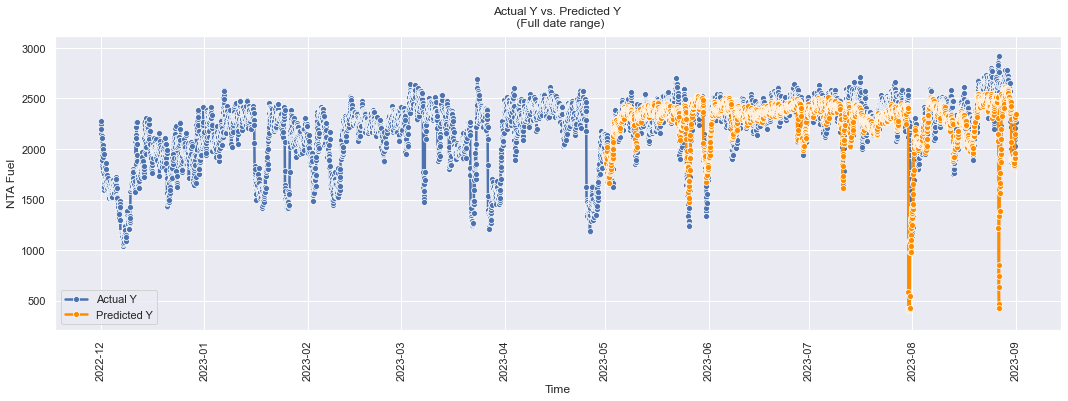

In [67]:
df_act_vs_prediction = display_prediction(raw_data, validation_data_raw)

In [92]:
def generate_weighted_err(df):
    
    # Applying data filters?
    apply_filter = input("Apply data filters?(yes / no): ")
    # if (apply_filter == '') or (apply_filter == 'no'):
    if apply_filter in ['', 'no', 'No', 'NO']:
        validation_data = df.copy()
        print('Raw data row number :',  df.shape[0] , 'rows')
    elif apply_filter in ['yes','Yes','YES']:
        print('apply filter:', apply_filter)
        validation_data, row_num0, row_num1, row_num2 = filter_y(df, Y)
        validation_data = generate_filtered_data(validation_data, row_num1, row_num2)

    actual_y, predicted_y = run_prediction(validation_data)

    # Calculate %err
    avg_err = round(np.mean(((actual_y - predicted_y)/(actual_y))*100), 4)
    print('Average Error: ', avg_err, '%')

    # Daily error calculation
    df_act_vs_prediction = pd.DataFrame(data=[validation_data.Timestamp.astype('str'), actual_y, predicted_y]).T\
                    .rename(columns={'Unnamed 0':'actual_y', 
                                     'Unnamed 1':'predicted_y'})
    df_act_vs_prediction['Timestamp'] = pd.to_datetime(df_act_vs_prediction['Timestamp'])

    df_monitoring = df_act_vs_prediction.reset_index(drop=True)
    df_monitoring['error_%'] = ((df_monitoring.actual_y - df_monitoring.predicted_y) / (df_monitoring.actual_y))*100
    df_monitoring['error_%'] = df_monitoring['error_%'].apply(lambda x: round(x, 4))

    # Set date range for error display
    # min_date = pd.to_datetime(input("Enter minimum date: ")) # Insert datetime input e.g. '2023-08-01'. Enter to skip.
    # max_date = pd.to_datetime(input("Enter maximum date: ")) # Insert datetime input e.g. '2023-08-31'. Enter to skip.
    min_date = input("Enter minimum date: ") # Insert datetime input e.g. '2023-08-01'. Enter to skip.
    max_date = input("Enter maximum date: ") # Insert datetime input e.g. '2023-08-31'. Enter to skip.

    if min_date == '':
        min_date = min(df_monitoring.Timestamp.dt.date)
    else: min_date = pd.to_datetime(min_date)

    if max_date == '':
        max_date = max(df_monitoring.Timestamp.dt.date)
    else: max_date = pd.to_datetime(max_date)

    df_display = df_monitoring[(df_monitoring.Timestamp.dt.date >= min_date) & (df_monitoring.Timestamp.dt.date <= max_date)]\
                                .reset_index(drop=True)
    

    # -------------------------------------------------------------------------------------------------------------------------
    # Prepping to generate moving average error by window size = 7
    date_list = np.sort(np.unique(df_display.Timestamp.dt.date))
    # i=0
    i = 6
    dates = []
    moving_avg_list = []
    
    
    # Define weights
    total_weight = 1+2+3+4+5+6+7
    w1 = 1/total_weight
    w2 = 2/total_weight
    w3 = 3/total_weight
    w4 = 4/total_weight
    w5 = 5/total_weight
    w6 = 6/total_weight
    w7 = 7/total_weight

    while (i < len(date_list)):
        df_averaging = df_display[df_display.Timestamp.dt.date.isin(date_list[i-6:i+1])].reset_index(drop=True)
        df_averaging['weighted_error_%'] = np.nan

        # Notes:
        # Current maximum limit for weighted moving average statistically is 1.3036.
        # Scale to 10 by multiplier: 10/1.3036 = 7.671

        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i], 
                                                    df_averaging['error_%'] * w7 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-1], 
                                                    df_averaging['error_%'] * w6 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-2], 
                                                    df_averaging['error_%'] * w5 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-3], 
                                                    df_averaging['error_%'] * w4 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-4], 
                                                    df_averaging['error_%'] * w3 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-5], 
                                                    df_averaging['error_%'] * w2 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = np.where(df_averaging['Timestamp'].dt.date == date_list[i-6], 
                                                    df_averaging['error_%'] * w1 *7.671, 
                                                    df_averaging['weighted_error_%'])
        df_averaging['weighted_error_%'] = df_averaging['weighted_error_%'].round(4)


        moving_avg = round(np.mean(np.abs(df_averaging['weighted_error_%'])), 4)

        # dates.append(date_list[i+6])
        # print(i)
        # print(date_list[i])
        # print(moving_avg)
        # print('')

        dates.append(date_list[i])
        moving_avg_list.append(moving_avg)

        i = i+1

    # # One time run to obtain maxv & maxv is fixed as upper limit in the chart
    # q1 = np.percentile(moving_avg_list, 25)
    # q3 = np.percentile(moving_avg_list, 75)
    # maxv = q3 + 1.5*(q3-q1)
    
    # Calculate average error / weighted error of the last 7 days
    df_last_7_days = df_averaging[(df_averaging.Timestamp.dt.date >= date_list[-7]) 
                                   & (df_averaging.Timestamp.dt.date <= date_list[-1])]\
                                .reset_index(drop=True)
    avg_err_7_days = round(np.mean(np.abs(df_last_7_days['error_%'])), 4)
    weighted_avg_err_7_days = round(np.mean(np.abs(df_last_7_days['weighted_error_%'])), 4)
    
    print('')
    print('Error % List          : ', df_last_7_days['error_%'].tolist())
    print('')
    print('Weighted Error % List : ', df_last_7_days['weighted_error_%'].tolist())
    print('')
    print('Average error         : ', avg_err_7_days, '%')
    print('Weighted average error: ', weighted_avg_err_7_days, '%')
    print('')
    
    
    figure(15,10)
    
    # ----------------------------------------------------------------------------------------------------------------------
    plt.subplot(2,1,1)
    sns.lineplot(df_display.Timestamp, 10, color='red', linestyle='dashed')
    sns.lineplot(df_display.Timestamp, 0, color='green', linestyle='dashed')
    sns.lineplot(df_display.Timestamp, -10, color='red', linestyle='dashed')
    sns.lineplot(df_display.Timestamp, df_display['error_%'], marker='o')
    
    # Annotation 
    plt.annotate('UCL', xy =(mdates.date2num(max(df_display.Timestamp)), 10), xytext =(mdates.date2num(max(df_display.Timestamp)), 10), color='blue')
    plt.annotate('Zero', xy =(mdates.date2num(max(df_display.Timestamp)), 0), xytext =(mdates.date2num(max(df_display.Timestamp)), 0), color='blue') 
    plt.annotate('LCL', xy =(mdates.date2num(max(df_display.Timestamp)), -10), xytext =(mdates.date2num(max(df_display.Timestamp)), -10), color='blue')
    
    plt.title('Daily errors monitoring (%)', pad=10)
    
    # ----------------------------------------------------------------------------------------------------------------------
    plt.tight_layout(pad=5.0)
    plt.subplot(2,1,2)
    sns.lineplot(dates, 10, color='red', linestyle='dashed')
    sns.lineplot(dates, 0, color='green', linestyle='dashed')

    sns.lineplot(dates, moving_avg_list, marker='o')
    plt.title('Weighted Absolute Error - Moving average Monitoring \n Window size: 7 days', pad=10)
    
    # Annotation 
    plt.annotate('UCL', xy =(mdates.date2num(date_list[-1]), 10), xytext =(mdates.date2num(date_list[-1]), 10), color='blue')
    plt.annotate('Zero', xy =(mdates.date2num(date_list[-1]), 0), xytext =(mdates.date2num(date_list[-1]), 0), color='blue') 

    plt.title('Weighted Moving average errors monitoring (%)', pad=10)
    plt.ylabel('Weighted errors_%')
    plt.xlabel('Timestamp')
    plt.savefig('../data/moving_avg.jpg')    
    
    plt.show()

    return df_act_vs_prediction, avg_err_7_days, weighted_avg_err_7_days

Apply data filters?(yes / no):  yes


apply filter: yes
Row filters

Raw data row number : 2952 rows
NTA Fuel > 0        : 0 rows
NG Fuel <= 0        : 0 rows
CO <= 4000          : 11 rows
Load > 50           : 0 rows
CO Flare MV < 3     : 32 rows
H2 Flare MV < 3     : 0 rows
CO Fuel < 500       : 545 rows
After filtering     : 2364 rows

% of row removal    :  19.92 %
Average Error:  0.7904 %


Enter minimum date:  2023-08-01
Enter maximum date:  2023-08-08



Error % List          :  [-0.867, 1.1573, 5.3186, 6.1639, 3.5898, 1.9836, 4.0421, -0.5878, 1.1736, 1.1007, 2.6567, 3.0474, 2.7053, 2.5249, 6.76, 3.3122, 0.4871, 3.5346, 2.468, 2.7815, 0.4835, -0.3762, 1.3982, 1.3608, -1.9547, 2.7202, 3.4431, 2.1749, 0.493, 0.8723, 1.4246, 4.5163, 1.5761, 2.5713, 1.349, 1.4747, 3.0173, 2.9061, -0.1508, 3.834, -1.7139, -2.6521, -1.3538, -1.894, -4.098, -1.5387, -1.1396, -2.2754, -2.4413, -3.5805, -2.4915, 0.4851, -0.2518, -1.5428, -3.368, -7.0197, -6.6437, -8.7934, -10.1298, -13.5515, -15.3827, -10.8315, -7.4903, -8.3716, -11.5348, -13.1744, -12.6467, -14.5658, -9.2317, -11.2155, -9.2066, -9.1087, -6.2333, -6.3941, -3.6748, -2.6946, -4.6696, -2.1154, 2.3344, -0.4899, -0.1423, -0.332, -0.3926, -0.2358, 1.9143, 2.4163, 4.3702, 0.1043, -3.505, -0.6463, 0.9999, 0.4466, -0.3853, -0.6612, 0.2139, 2.5031, 2.7035]

Weighted Error % List :  [-0.2375, 0.3171, 1.4571, 1.6887, 0.9835, 0.5434, 1.1074, -0.3221, 0.643, 0.6031, 2.1835, 2.5046, 2.2235, 2.0752, 5.556, 2.

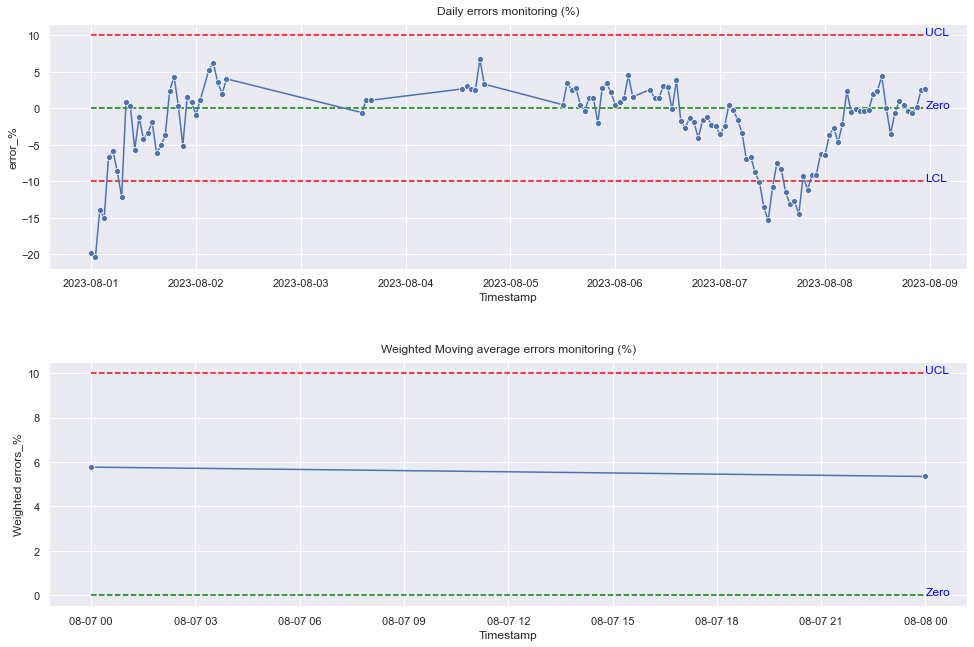

In [95]:
df_act_vs_prediction, avg_err_7_days, weighted_avg_err_7_days = generate_weighted_err(validation_data_raw)

In [96]:
if weighted_avg_err_7_days >= 10:
    print('Notification: Moving average error ', weighted_avg_err_7_days, '%. Run model retraining.')
else:
    print('Notification: Moving average error is within control at ', weighted_avg_err_7_days, '%.')

Notification: Moving average error is within control at  5.3454 %.
